# Defining the model

In [1]:
# only for colab
# ! pip install --upgrade albumentations

In [2]:
import torch
import importlib
from tqdm.notebook import tqdm


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
!nvidia-smi

Fri Dec 10 00:17:27 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.86       Driver Version: 470.86       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:0A:00.0  On |                  N/A |
| 50%   37C    P0    88W / 320W |    875MiB / 10014MiB |     46%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

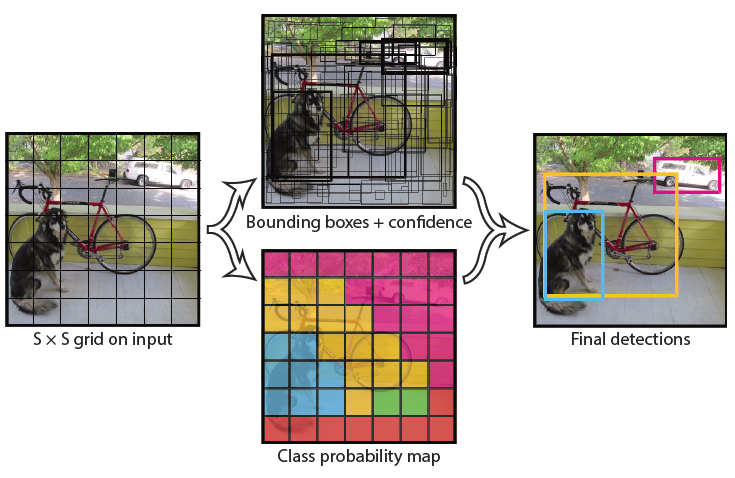

In [4]:
import dataset
import utils
import architecture
import wandb

from torch.optim import SGD
from torch.optim import Adam

In [5]:
wandb.login()

wandb: Currently logged in as: bindas1 (use `wandb login --relogin` to force relogin)


True

## Architecture
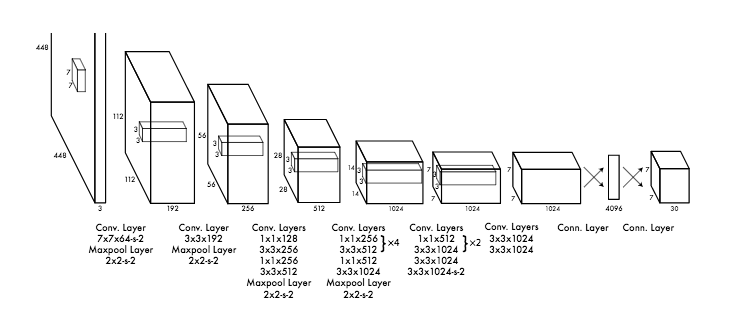

In [6]:
net = architecture.darknet(batch_norm=True)
# print(net)

## Training

To avoid overfitting:
- dropout is used with rate 0.5 after the first connected layer
- extensive data augmentation is used - random scaling and translations of up to 20% of the original image size
- also randomly adjust the exposure and saturation of the image by up to factor of 1.5 in the HSV color space

### Constants

In [7]:
# from the paper
MOMENTUM = 0.9
EPOCHS = 100
DECAY = 0.0005
# model is trained with 135 epochs
# first 5 epochs from 0.001 to 0.1
# 75 epochs 0.01 epochs
# 30 epochs 0.001
# 30 epochs 0.0001
LEARNING_RATE = 0.00001
LAMBDA_NOOBJ = 0.5
LAMBDA_COORD = 5
SMOOTH = 1e-6

In [8]:
config = dict(
    epochs=EPOCHS,
    classes=20,
    batch_size=8,
    learning_rate=LEARNING_RATE,
    dataset="VOC2007trainval",
    batch_norm=True,
    is_onebatch=True,
    optimizer="SGD",
    momentum=MOMENTUM
)

In [9]:
# importlib.reload(utils)

Using downloaded and verified file: ./data/VOCtrainval_06-Nov-2007.tar
Extracting ./data/VOCtrainval_06-Nov-2007.tar to ./data
Using downloaded and verified file: ./data/VOCtest_06-Nov-2007.tar
Extracting ./data/VOCtest_06-Nov-2007.tar to ./data
Feature batch shape for training: torch.Size([8, 3, 448, 448])
Objects batch shape for training: 8
Labels matrix batch shape for training: torch.Size([8, 7, 7, 25])
Sample batch for training dataloader is presented below:


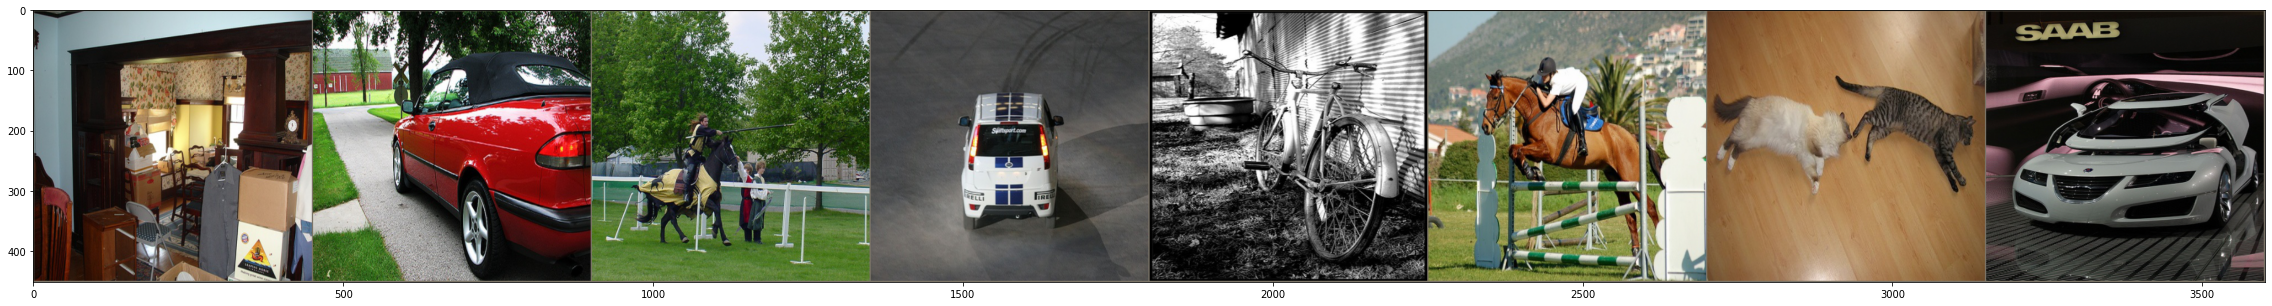

In [10]:
train_dl_predef, test_dl_predef = dataset.prepare_data(config["batch_size"])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


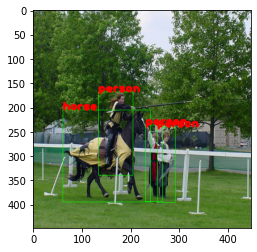

In [11]:
image, labels, _ = iter(train_dl_predef).next()
utils.show_image_with_classes(image[2], labels[2])

### IOU

Implemented in utils.py

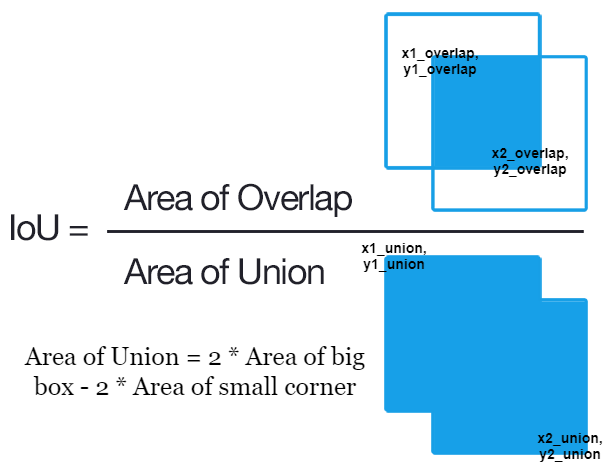

### LOSS

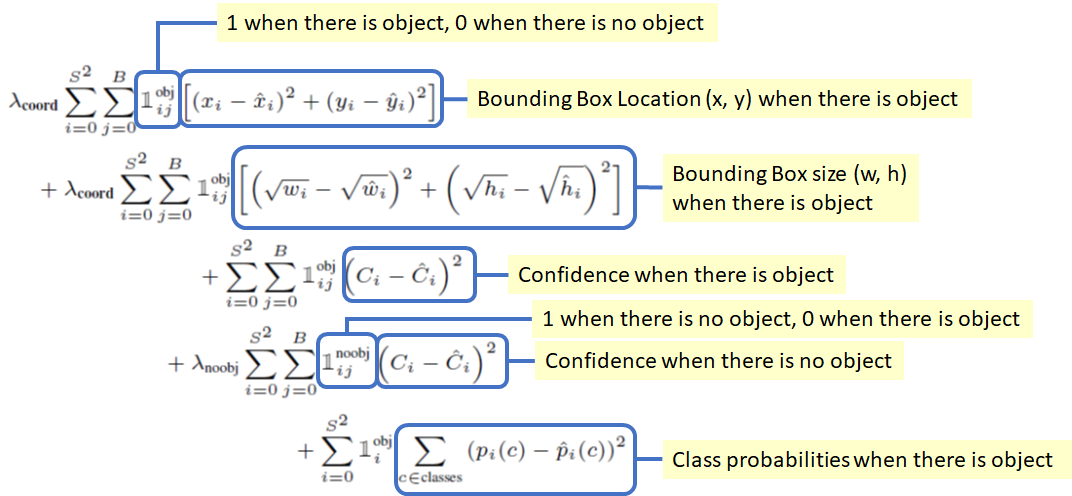

In [12]:
# for details check loss.py

import loss
from loss import YoloLoss

### Training pipeline

In [13]:
def train_log(loss, example_ct, epoch):
    # Where the magic happens
    wandb.log({"epoch": epoch, "loss": loss}, step=example_ct)
    print(f"Loss after " + str(example_ct).zfill(5) + f" examples: {loss:.3f}")

In [14]:
def train_batch(images, labels, model, optimizer, criterion):
    images, labels = images.to(device), labels.to(device)
    
    # Forward pass ➡
    outputs = model(images)
    loss = criterion(outputs, labels)
    
    # Backward pass ⬅
    optimizer.zero_grad()
    loss.backward()

    # Step with optimizer
    optimizer.step()
    
    size = images.size(0)
    del images, labels
    return loss, size

In [15]:
import loss
from loss import YoloLoss

# train the model
def train(model, train_dl, criterion, optimizer, config, is_one_batch):
    # Tell wandb to watch what the model gets up to: gradients, weights, and more!
    wandb.watch(model, criterion, log="all")
    
    # enumerate epochs
    for epoch in tqdm(range(config.epochs)):
        running_loss = 0.0
        
        if not is_one_batch:
            for i, (inputs, _, targets) in enumerate(train_dl):
                loss, batch_size = train_batch(inputs, targets, model, optimizer, criterion)
                running_loss += loss.item() * batch_size
        else:
            # for one batch only
            loss, batch_size = train_batch(train_dl[0], train_dl[2], model, optimizer, criterion)
            running_loss = loss.item() * batch_size
            
        running_loss = running_loss / len(train_dl)
#         loss_values.append(epoch_loss)
        wandb.log({"epoch": epoch, "avg_batch_loss": running_loss})
#         wandb.log({"epoch": epoch, "loss": loss}, step=example_ct)
        print("Average epoch loss {}".format(running_loss))
    
#     plot_loss(loss_values)

In [16]:
def make(config, is_one_batch, data_predefined=True):
    optimizers = {
        "Adam":torch.optim.Adam,
        "SGD":torch.optim.SGD
    }
    
    if data_predefined:
        train_dl, test_dl = train_dl_predef, test_dl_predef
    else:
        train_dl, test_dl = dataset.prepare_data(config.batch_size)
        
    if is_one_batch:
        train_dl = next(iter(train_dl))
        test_dl = train_dl
    
    # Make the model
    model = architecture.darknet(config.batch_norm)
    model.to(device)

    # Make the loss and optimizer
    criterion = YoloLoss()
    optimizer = optimizers[config.optimizer](
        model.parameters(), 
        lr=config.learning_rate,
        momentum=config.momentum
    )
    
    return model, train_dl, test_dl, criterion, optimizer
        

In [17]:
def evaluate(model, test_loader):
    ...

In [18]:
def model_pipeline(hyp, is_one_batch=False, device=device):
    with wandb.init(project="YOLO-recreated", entity="bindas1", config=hyp):
        config = wandb.config
        
        # make the model, data, and optimization problem
        model, train_dl, test_dl, criterion, optimizer = make(config, is_one_batch)
        
        # and use them to train the model
        train(model, train_dl, criterion, optimizer, config, is_one_batch)

        # and test its final performance
#         evaluate(model, test_dl)
        
    return model

## Non-maximal suppression

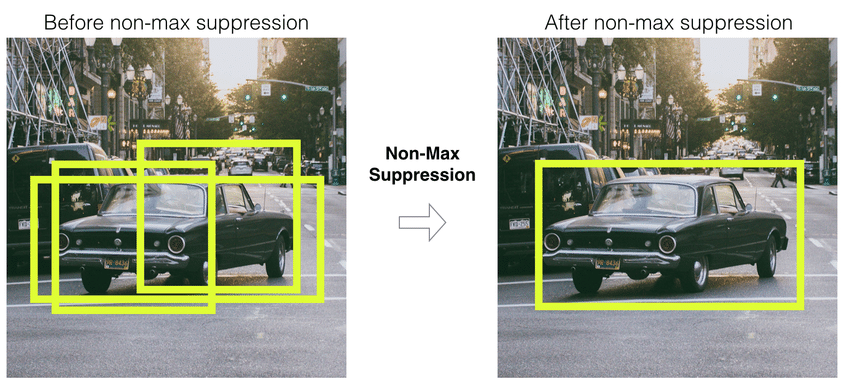

Source: https://www.researchgate.net/figure/Non-Maximal-Suppression_fig5_345061606

For large objects it's hard to tell in which cell they should be localized. Non-maximal suppression is used to fix multiple detecions of one object.

In [19]:
# done in utils.py

## Evaluation (TODO)

In [20]:
def evaluate_model():
    # TODO
    ...

### MAP

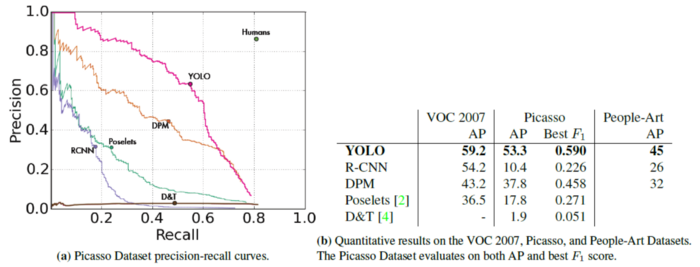

Source: YOLOv1 paper

In [21]:
def mean_average_precision():
  # TODO
    ...

### Precision / recall curve

https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html

In [22]:
def precision_recall_curve():
    # TODO
    ...

## MAIN

In [23]:
model = model_pipeline(config, is_one_batch=True)

  0%|          | 0/100 [00:00<?, ?it/s]

Average epoch loss 437.2080063858098
Average epoch loss 290.8346839352948
Average epoch loss 218.14058024441184
Average epoch loss 209.15548335257344
Average epoch loss 175.9981673671609
Average epoch loss 152.4451074975888
Average epoch loss 116.63818899724363
Average epoch loss 115.93740081113788
Average epoch loss 91.61822901533635
Average epoch loss 110.33606903154309
Average epoch loss 122.84007502060273
Average epoch loss 91.09667784853944
Average epoch loss 61.35972425577966
Average epoch loss 51.79197997299426
Average epoch loss 47.67022500097178
Average epoch loss 47.28659344984387
Average epoch loss 44.518587297595815
Average epoch loss 37.9974093914278
Average epoch loss 26.264218512739166
Average epoch loss 16.749530438478523
Average epoch loss 12.830001590940816
Average epoch loss 10.582580710415256
Average epoch loss 7.799668486109656
Average epoch loss 5.996684855535733
Average epoch loss 5.061766517131603
Average epoch loss 3.7210357994971357
Average epoch loss 3.188001

avg_batch_loss,█▄▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
avg_batch_loss,0.00319
epoch,99


In [24]:
# for lr in [0.000001, 0.000005, 0.00001, 0.00005, 0.0001]:
#     model = architecture.darknet()
#     model.to(device)
#     optimizer = SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
#     #     train_dl, test_dl = dataset.prepare_data()
#     train_dl_main, test_dl_main = train_dl, test_dl
#     one_batch = next(iter(train_dl))
#     train_model(one_batch, model)

In [25]:
one_batch = next(iter(train_dl_predef))
one_batch[2].size()

torch.Size([8, 7, 7, 25])

In [26]:
predictions, targets = utils.pred_and_target_boxes(one_batch, model, single_batch=True)

In [27]:
targets[0]

[0,
 15.0,
 1.0,
 0.4820000231266022,
 0.5173333287239075,
 0.5900000333786011,
 0.797333300113678]

In [28]:
one_batch[0][2].size()

torch.Size([3, 448, 448])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


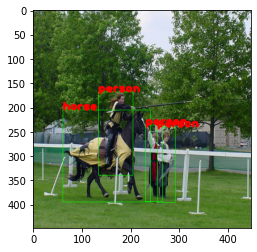

In [29]:
utils.show_image_with_classes(one_batch[0][2], one_batch[1][2])

In [30]:
classes_dict = {'person': 0, 'bird': 1, 'cat': 2, 'cow': 3, 'dog': 4, 'horse': 5, 'sheep': 6, 'aeroplane': 7,
                'bicycle': 8, 'boat': 9, 'bus': 10, 'car': 11, 'motorbike': 12, 'train': 13, 'bottle': 14,
                'chair': 15, 'dining table': 16, 'potted plant': 17, 'sofa': 18, 'tvmonitor': 19}

inv_classes_dict = {v: k for k, v in classes_dict.items()}
inv_classes_dict[predictions[0][1]]

'chair'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


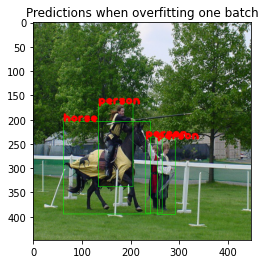

In [42]:
import cv2
import matplotlib.pyplot as plt

FONT = cv2.FONT_HERSHEY_PLAIN
green = (0, 255, 0)
red = (255, 0, 0)
thickness = 1
font_size = 1.5

i=2

un_norm = dataset.DeNormalize(dataset.MEAN, dataset.STD)
# denormalize the image
npimg = un_norm(one_batch[0][i].clone()).numpy()
npimg = npimg.transpose((1, 2, 0)).copy()

for idx, class_no, conf, x, y, x2, y2 in predictions:
    if idx == i:
        x, y, x2, y2 = int(x*448), int(y*448), int(x2*448), int(y2*448)
        cv2.rectangle(npimg, (x, y), (x2, y2), green, thickness)
#         cv2.putText(npimg, "{:.2f}".format(class_no), (x, y), FONT, font_size, red, thickness + 2)
        cv2.putText(npimg, inv_classes_dict[class_no], (x, y), FONT, font_size, red, thickness + 2)
        # cv2.putText(npimg, "{:.3f}".format(conf), (x, y), FONT, font_size, red, thickness + 2)

# Display the image
plt.title("Predictions when overfitting one batch")
plt.imshow(npimg)

### Old pipeline

In [1]:
def train_model(train_dl, model, is_one_batch=False):
    # define the optimization
    criterion = YoloLoss()
    optimizer = SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
    
    # for loss plotting
    loss_values = []
    
    # enumerate epochs
    for epoch in tqdm(range(EPOCHS)):
        if epoch % 10 == 0:
            print(epoch)
        running_loss = 0.0
        
        if not is_one_batch:
        # enumerate mini batches
            for i, (inputs, _, targets) in enumerate(train_dl):
                inputs = inputs.to(device)
                targets = targets.to(device)
                # clear the gradients
                optimizer.zero_grad()
                # compute the model output
                yhat = model(inputs)
                # calculate loss
                loss = criterion(yhat, targets)
                # credit assignment
                loss.backward()
#                 print(loss)
                running_loss =+ loss.item() * inputs.size(0)
                # update model weights
                optimizer.step()
        else:
            # for one batch only
            with torch.autograd.detect_anomaly():
                inputs, targets = train_dl[0].to(device), train_dl[2].to(device)
                optimizer.zero_grad()
                # compute the model output
                yhat = model(inputs)
                # calculate loss
                loss = criterion(yhat, targets)
                # credit assignment
                loss.backward()
                print(loss)
                running_loss =+ loss.item() * inputs.size(0)
                # update model weights
                optimizer.step()
        loss_values.append(running_loss / len(train_dl))
    
    plot_loss(loss_values)

In [2]:
model = architecture.darknet()
model.to(device)
optimizer = SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
#     train_dl, test_dl = dataset.prepare_data()
train_dl_main, test_dl_main = train_dl_predef, test_dl_predef
one_batch = next(iter(train_dl_main))
train_model(one_batch, model, is_one_batch=True)

NameError: name 'architecture' is not defined

In [3]:
def plot_loss(loss_values):
    plt.plot(loss_values)
    plt.ylabel("YOLO loss")
    plt.xlabel("Epoch")
    plt.title("Loss values during training")